load checkpoint from http path: https://download.openmmlab.com/mmpose/face/hrnetv2/hrnetv2_w18_aflw_256x256-f2bbc62b_20210125.pth


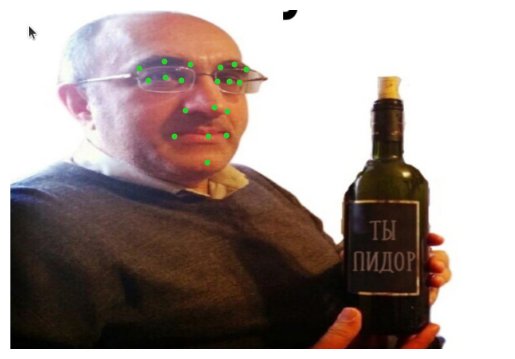

In [18]:
import image_getter
img = input()
dict = image_getter.ImageGetter(img)
dict.show()

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [20]:
class ImageHandler():

    def __init__(self, data):
        self.image = data['image']
        keypoints = data['keypoints']
        self.keypoints_x = keypoints[:, 0]
        self.keypoints_y = keypoints[:, 1]
        marker_id = ['l_eyebrow', 'r_eyebrow', 'l_eye', 
             'r_eye', 'nose', 'mouth', 'beard']
        marker_split = np.array([0, 3, 6, 9, 12, 15, 18, 19])
        self.marker_dict = { marker_id[i]: (marker_split[i], marker_split[i+1]) 
                            for i in range(len(marker_split)-1) }
    
    def segmentation(self):
        segments_dict = {}
        for label, (start, end) in self.marker_dict.items():
            it_x = self.keypoints_x[start:end]
            it_y = self.keypoints_y[start:end]
            segments_dict[label] = (it_x, it_y)
        return segments_dict

    def segmshow(self):
        plt.axis('off')
        plt.imshow(self.image)
        for label, (start, end) in self.marker_dict.items():
            it_x = self.keypoints_x[start:end]
            it_y = self.keypoints_y[start:end]
            plt.scatter(it_x, it_y, label=label)
        plt.legend(loc=2, prop={'size': 6})



class EyesFilter(ImageHandler):

    def __init__(self, data, filter_path):
        super().__init__(data)
        self.segments_dict = super().segmentation()
        self.image = np.copy(self.image)
        self.filter_path = filter_path

    def overlay(self):
        x_top_left = int(self.segments_dict['l_eyebrow'][0][0])
        y_top_left = int(self.segments_dict['l_eyebrow'][1][0])
        high = int(abs(self.segments_dict['l_eye'][1][2] - self.segments_dict['nose'][1][0]))
        width = int(abs((self.segments_dict['r_eyebrow'][0][2]) - (self.segments_dict['l_eyebrow'][0][0])))
        eye_high = int(abs((self.segments_dict['r_eyebrow'][1][2]) - (self.segments_dict['l_eyebrow'][1][0])))
        corner = np.arctan(np.array(eye_high / width))
        filter = cv2.imread(self.filter_path, cv2.IMREAD_UNCHANGED)
        filter = cv2.resize(filter, (width, high), interpolation=cv2.INTER_CUBIC)
        print(filter.shape)
        roi = self.image[y_top_left:y_top_left+high, x_top_left:x_top_left+width]
        filter_it = np.argwhere(filter[:,:,3] > 0)
        for i in range(3):
            roi[filter_it[:,0], filter_it[:,1], i] = filter[filter_it[:,0], filter_it[:,1], i]
        self.image[y_top_left:y_top_left+high, x_top_left:x_top_left+width] = roi
        return self.image

(38, 134, 4)


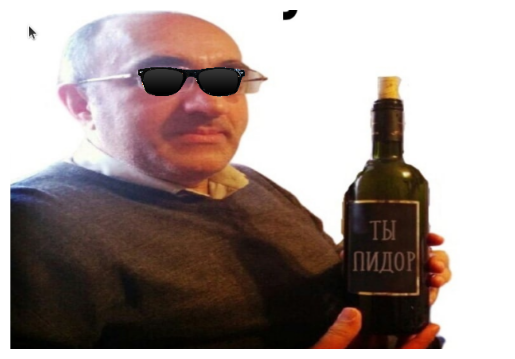

In [21]:

data = dict.get()
filter_path = './filters/sunglasses.png'
data1 = EyesFilter(data, filter_path)
image = data1.overlay()
plt.axis('off')
plt.imshow(image)